In [1]:
# !pip uninstall shapely -y; pip install --no-binary :all: shapely; pip install contextily

In [2]:
import torch
import torch.nn as nn

import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import contextily as ctx
import matplotlib.pyplot as plt

import model, model_utils, preprocessing_utils

In [3]:
num_timesteps_input = 7 # 35 minutes
num_timesteps_output = 4 # 20 minutes
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
loaded_model, loaded_optimizer = model_utils.load_model(path=None)

Loading model in path : ./saved_models/20210425/19_56_10


In [5]:
raw_trunc_dir = "./data/raw/trunc/"
process_dir = "./data/processed/"

# overwrite = False means that the processing function will only run if the process data files do not exist
# overwrite = True => functions will run regardless
preprocessing_utils.processed(raw_trunc_dir, process_dir, overwrite=False)
A, X, metadata, cat2index, means, stds = preprocessing_utils.load(process_dir)

split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.8)

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

training_input, training_target = preprocessing_utils.generate_dataset(train_original_data,
                                                   num_timesteps_input=num_timesteps_input,
                                                   num_timesteps_output=num_timesteps_output)
val_input, val_target = preprocessing_utils.generate_dataset(val_original_data,
                                         num_timesteps_input=num_timesteps_input,
                                         num_timesteps_output=num_timesteps_output)
test_input, test_target = preprocessing_utils.generate_dataset(test_original_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)

# input shape (num_samples ,num_vertices, num_timesteps_window, num_features)
# output shape (num_samples ,num_vertices, num_timesteps_window)
adj_mat = preprocessing_utils.get_normalized_adj(A)
adj_mat = torch.from_numpy(adj_mat).to(device)

In [6]:
loaded_model.to(device)
with torch.no_grad():
    predicted = model_utils.predict(loaded_model, test_input, adj_mat)

In [7]:
def rmsePerLink(predicted, actual):
    rmses = []
    for i in range(predicted.shape[1]):
        linkPreds = predicted[:,i,:]
        linkActs = actual[:,i,:]
        rmse = nn.MSELoss()(linkPreds, linkActs).sqrt()
        rmses.append(rmse.item())
    return rmses

def loc_to_linestring(loc):
    coordArr = loc.split()
    coordArr = [float(coord) for coord in coordArr]
    return LineString([coordArr[1::-1], coordArr[3:1:-1]])

def plotGeoPerformance(metadata, rmses):
    df = pd.DataFrame(metadata).transpose()
    df["RMSE"] = rmses
    loc = df["start_pos"] + " " + df["end_pos"]
    linestrings = loc.apply(loc_to_linestring)
    gdf = gpd.GeoDataFrame(df, geometry=linestrings, crs="EPSG:4326")
    gdf = gdf.to_crs('EPSG:3857')
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, column="RMSE", legend=True, cmap="OrRd", legend_kwds={'label': 'RMSE'})
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ctx.add_basemap(ax)

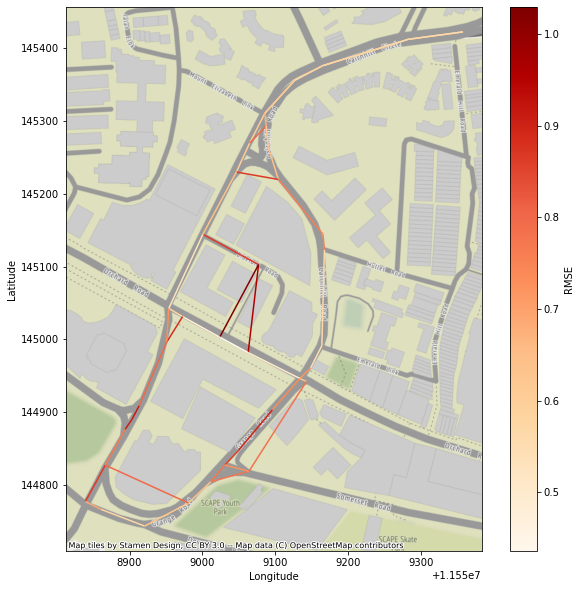

In [8]:
predicted_denorm = preprocessing_utils.denormalize(predicted.to("cpu"), stds[0], means[0])
actual_denorm = preprocessing_utils.denormalize(test_target, stds[0], means[0])

rmses = rmsePerLink(predicted_denorm, actual_denorm)
plotGeoPerformance(metadata, rmses)